# Certificate in Data Science | Assignment 4 |  
- Automobile Price Hypothesis Testing

> University of Washington  
> August 2019  
> N. HICKS

## Instructions
Test hypotheses for the price of automobiles:

1. Compare and test the normality of the distributions of **price** and **log price**. <br/>
Use both a graphical method and a formal test. Hint: remember these relationships will always be approximate.

2. Test significance of **price (or log price)** stratified by 
a) **fuel type**, b) **aspiration**, and c) **rear vs. front wheel drive**. <br />Use both graphical methods and the formal test.

3. Apply ANOVA and Tukey's HSD test to the auto price data to compare the **price (or log price** if closer to a normal distribution) of autos stratified by **body style**.

4. Graphically explore the differences between the price conditioned by the categories of each variable. <br/>
Hint: Make sure you have enough data for each category and drop categories with insufficient data.

5. Use standard ANOVA and Tukey HSD to test the differences of these groups.


Note:  
Please clearly outline the results of these tests with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from sklearn import preprocessing
import statsmodels.stats.power as smsp
from scipy import stats
import scipy.stats as ss
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
try:
    # import the file to a dataframe
    auto_df = pd.read_csv(fileName)
    print('REMOTE FILE USED')
except:
    # Local Copy -- Link would not permit access
    fileName = 'C://Users//NateDogg//Desktop//_notebooks//Automobile_Price_Data_Raw.csv'
    print('LOCAL FILE USED\n--> remote server is unavailable')
# import the file to a dataframe
auto_df = pd.read_csv(fileName)

LOCAL FILE USED
--> remote server is unavailable


In [ ]:
# validate the dataframe contents
auto_df.info()

## Item 1: Graphical Method

### PLOT EACH POPULATION VIA HISTOGRAM

In [3]:
# 1.Compare and test the normality of the distributions of price and log price. 
#  Use both a graphical method and a formal test. Hint: remember these relationships will always be approximate.

# ensure missing values and special characters are handled, to enable further dataframe processing
whiteList = ['price']   # a white list of unique variable assignments, for dataframe calculations that require Natural Log
val = 1
for item in whiteList:
    auto_df.replace('?', val, inplace=True)
    auto_df.fillna(val, inplace=True)
val = 0
# auto_df.replace('?', val, inplace=True)
# auto_df.fillna(val, inplace=True)
auto_df = auto_df.astype({'price':int})

In [4]:
# establish a new calculated feature: the Log of Auto Price, per this assignment requirement 1
logList = np.log(auto_df['price'])
locPrice = auto_df.columns.get_loc('price')
auto_df.insert(loc=locPrice+1, column='logPrice', value=logList)

In [5]:
%matplotlib inline
sns.set()
figArea = (15,6)   # width, height of the resulting figures below
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
def plot_pop(a, b, cols=['pop_A', 'pop_B'], nbins = 25):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    # change the figure dimensions
    plt.figure(figsize=figArea)
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograms of Auto Prices and Auto Log Prices', fontsize='14')
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
    plt.show()

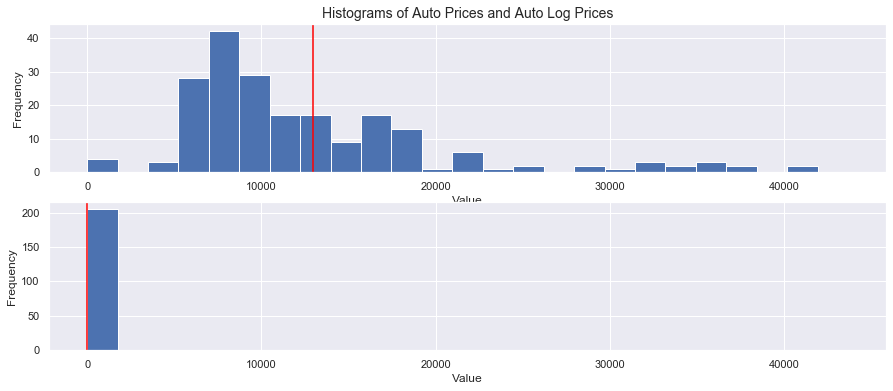

In [6]:
pop_A = auto_df['price']
pop_B = auto_df['logPrice']
# note that populations are not normalized
plot_pop(pop_A, pop_B, cols=['price', 'logPrice']) 

### NORMALIZE  BOTH POPULATIONS AND COMPARE HISTOGRAMS

In [7]:
# REF: https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc

# Normalize a feature column
def getNormalCol(df, column):
    x_array = np.array(df[column])
    normalized_X = preprocessing.normalize([x_array])
    return normalized_X

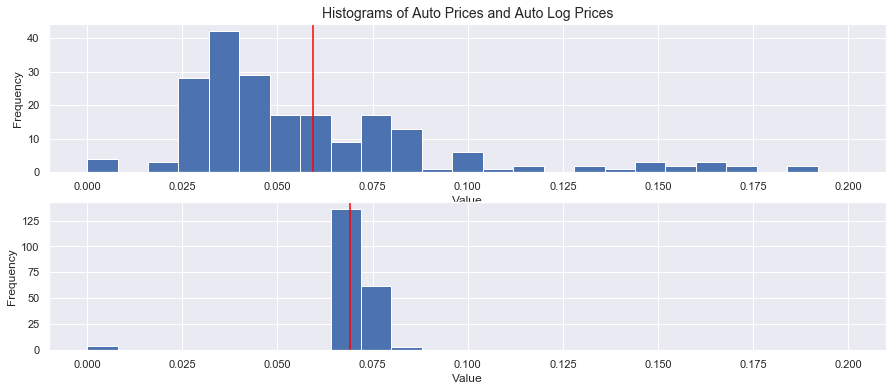

In [8]:
# normalize the dataframe
normA = getNormalCol(auto_df, 'price')
normB = getNormalCol(auto_df, 'logPrice')
normA = normA[0]
normB = normB[0]

# note the populations are now normalized
plot_pop(normA, normB, cols=['Auto Price', 'logPrice']) 

## Item 1: Formal Hypothesis Method

### T-TEST

In [9]:
# use a t-test to compare hypothesis test outcomes
def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b, equal_var=False)
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal')
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference', 't-Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)

t_testResult = t_test(normA, normB, 0.05)
t_testResult

DegFreedom     236.408867
Difference      -0.009762
t-Statistic     -3.635726
PValue           0.000340
Low95CI         -0.015052
High95CI        -0.004473
dtype: float64

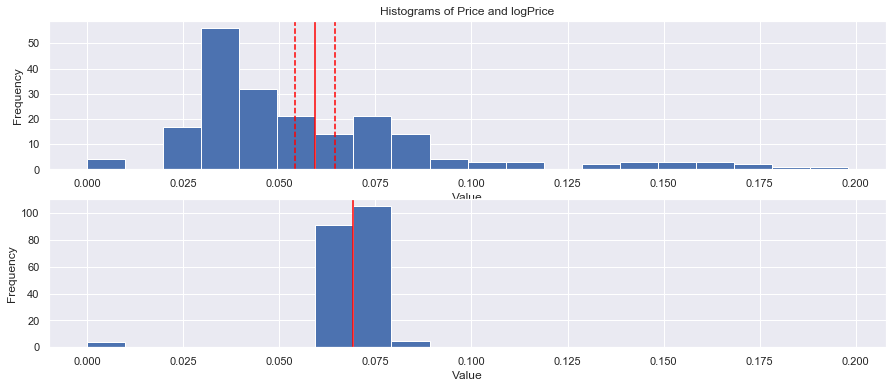

In [10]:
def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['Price', 'logPrice'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.figure(figsize=figArea)
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograms of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
plot_t(normA, normB, t_testResult)

### Item 1: Results  
> Examine these statistics noticing the following:
1. Difference in means is small.
2. The t-statistic is large and the p-value is small. Therefore, there is a high chance that the difference in means is NOT from random variation alone. 
3. The 95% confidence interval DOES NOT straddle 0.  

Based on these statistics we can reject the null hypothesis.   
***NOTE***: The two-sided t-test is used to determine if the null hypothesis can be rejected - that the difference of means is not significant.

## Item 2: Stratify the Population

2.Test significance of price (or log price) stratified by a) fuel type, b) aspiration, and c) rear vs. front wheel drive.  
   Use both graphical methods and the formal test.

In [11]:
## stratify the dataframe by the given category
def stratify(dat, p, category):
    groups = dat.groupby(category) # Create the groups
    nums = min(groups.size()) # Find the size of the smallest group
    num = int(p * dat.shape[0]) # Compute the desired number of samples per group
    if num <= nums: # If sufficient group size, sample each group and return. 
        return groups.apply(lambda x: x.sample(n=num))
    else: # Oops. p is to large
        pmax = nums / dat.shape[0]
        print('   - Chosen p value is too large.')
        print('     The maximum value of p = ' + str(pmax))
        
def plot_power(x, y, xlabel, title):
    plt.plot(x, y, color = 'red', linewidth = 2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Power')

## Item 2: Graphical Method  
> - DETERMINE POWER VS. NUMBER OF OBSERVATIONS  
> - DETERMINE POWER VS. SIGNIFICANCE LEVEL

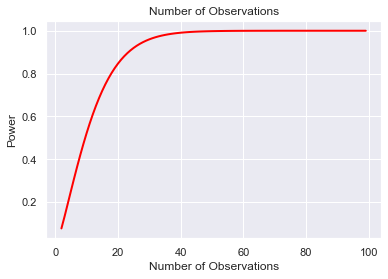


* fuel-type
  - Observations: 16

* aspiration
  - Observations: 16

* drive-wheels
  - Observations: 16


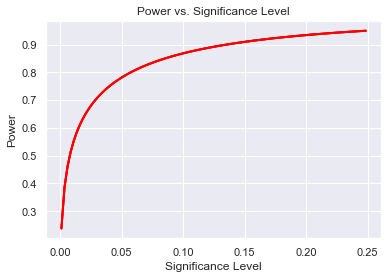

In [12]:
p = 0.04
#determine the significance
nobs = np.arange(start = 1.0, stop = 100.0, step = 1.0)
powers = [smsp.tt_ind_solve_power(effect_size = 1.0, nobs1 = x,
          alpha = p, power = None, ratio = 1.0, alternative = 'two-sided')
          for x in nobs]
plot_power(nobs, powers, xlabel = 'Number of Observations', title = 'Number of Observations') 
plt.show()
    
columnNames = ['fuel-type', 'aspiration', 'drive-wheels']
for col in columnNames:
    stratified = stratify(auto_df, p, col)
    if col=='drive-wheels': stratified = stratified[stratified[col] != '4wd']
    stratified.reset_index(inplace=True, drop=True)
    print('\n* ' + str(col))
    print('  - Observations: ' + str(stratified.shape[0]))
    count = stratified.shape[0]
    alphas = np.arange(start = 0.001, stop = 0.25, step = 0.0025)
    powers = [smsp.tt_ind_solve_power(effect_size = 1.0, nobs1 = count,
               alpha = x, power = None, ratio = 1.0, alternative = 'two-sided') 
              for x in alphas]
    plot_power(alphas, powers, xlabel = 'Significance Level', title = 'Power vs. Significance Level')
plt.show()

From the first plot above, the resulting power based upon 16 samples is ~0.6.  
Thus, from the second plot shown above, a power of 0.6 has a significance level of ~0.0167, rather, ~1/3*(0.05-0.00).

## Item 2: Statistical Method  
> - FORMAL METHOD  
> - GRAPHICAL METHOD

fuel-type:
DegFreedom     1.633246e+01
Difference    -1.805728e-01
t-Statistic   -5.049062e+01
PValue         2.268786e-19
Low95CI       -1.885530e-01
High95CI      -1.725927e-01
dtype: float64

aspiration:
DegFreedom     1.656055e+01
Difference    -1.806256e-01
t-Statistic   -5.437906e+01
PValue         4.182322e-20
Low95CI       -1.880285e-01
High95CI      -1.732227e-01
dtype: float64

drive-wheels:
DegFreedom     2.330158e+01
Difference    -1.304124e-01
t-Statistic   -1.438633e+01
PValue         4.406321e-13
Low95CI       -1.501313e-01
High95CI      -1.106935e-01
dtype: float64



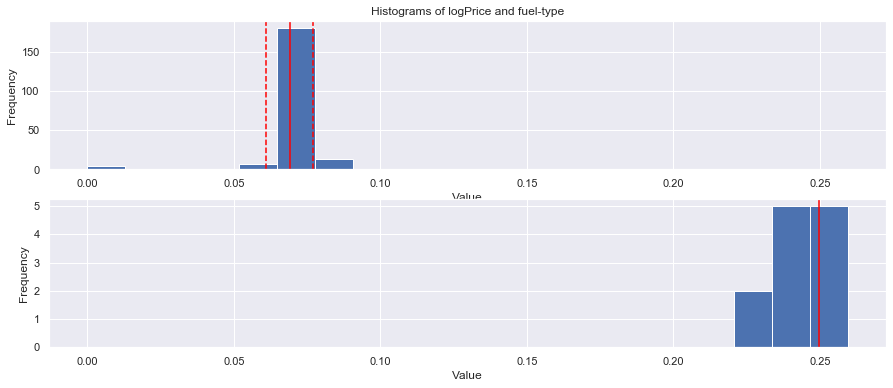

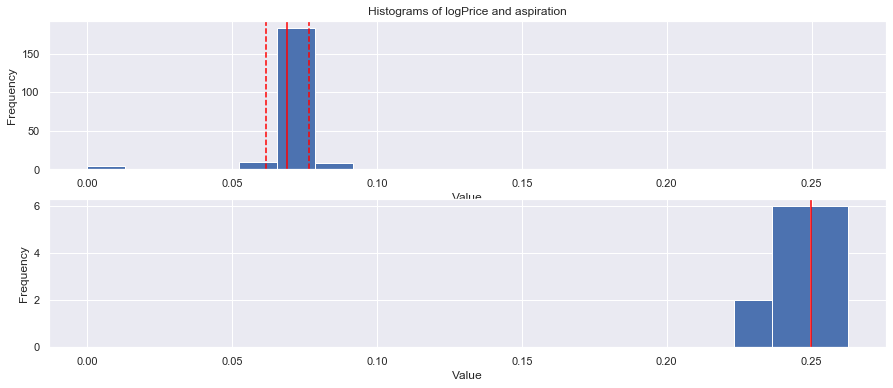

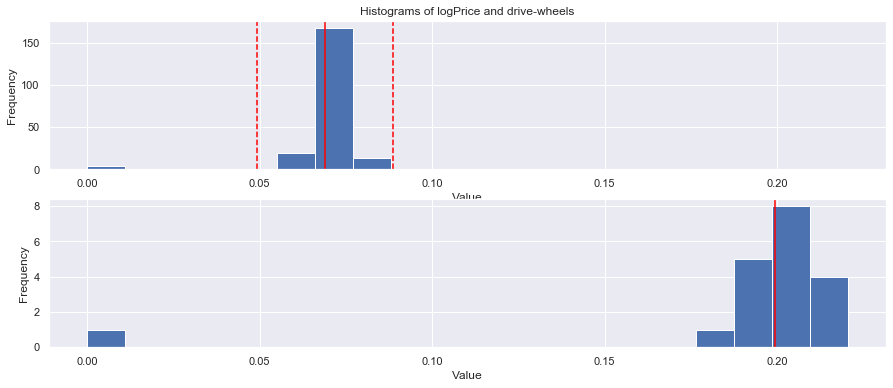

In [13]:
p=0.04
columnNames = ['fuel-type', 'aspiration', 'drive-wheels']
for col in columnNames:
    stratified = stratify(auto_df, p, col)
    stratified.reset_index(inplace=True, drop=True)
    # normalize the dataframe
    logCost = getNormalCol(stratified, 'logPrice')
    normB = getNormalCol(auto_df, 'logPrice')
    logCost = logCost[0]
    normB = normB[0]
    
    cols = ['logPrice', col]
    t_testResult = t_test(normB, logCost, p)
    print(col + ':\n' + str(t_testResult) + '\n')
    plot_t(normB, logCost, t_testResult, cols=cols)

## Item 2 Results  
> Examine these statistics noticing the following:
1. Difference in means is small.
2. The t-statistic is large and the p-value is small. Therefore, there is a high chance that the difference in means is NOT from random variation alone. 
3. The 96% confidence interval DOES NOT straddle 0.  

Based on these statistics we can reject the null hypothesis (that the selected features do not effect the cost of an automobile).  
***NOTE***: The two-sided t-test is used to determine if the null hypothesis can be rejected - that the difference of means is not significant.

## Item 3: STRATIFY THE POPULATION

### Feature Box Plots

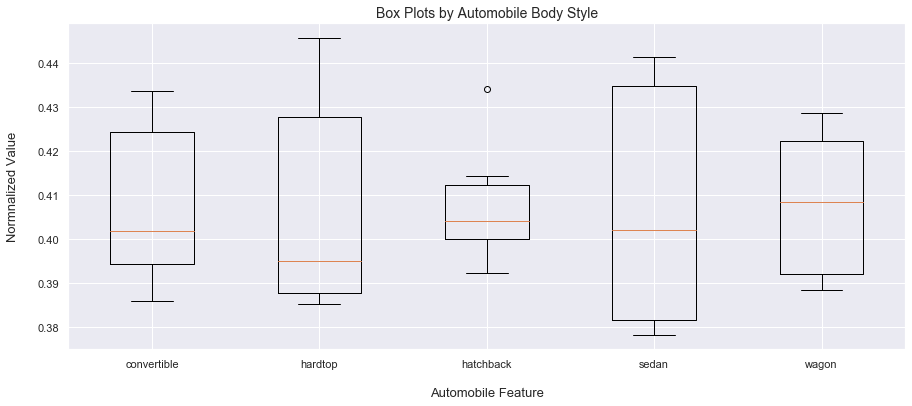

In [14]:
p=.03
stratified = stratify(auto_df, p, 'body-style')
categories = ['convertible', 'hardtop', 'hatchback', 'sedan', 'wagon']
# CONVERTIBLE
strat_convertible = stratified['body-style'] == categories[0]
strat_convertible = stratified[strat_convertible]
strat_convertible.reset_index(inplace=True, drop=True)
stratLog_convertible = getNormalCol(strat_convertible, 'logPrice').tolist()
stratLog_convertible = stratLog_convertible[0]
# HARDTOP
strat_hardtop = stratified['body-style'] == categories[1]
strat_hardtop = stratified[strat_hardtop]
strat_hardtop.reset_index(inplace=True, drop=True)
stratLog_hardtop = getNormalCol(strat_hardtop, 'logPrice').tolist()
stratLog_hardtop = stratLog_hardtop[0]
# HATCHBACK
strat_hatchback = stratified['body-style'] == categories[2]
strat_hatchback = stratified[strat_hatchback]
strat_hatchback.reset_index(inplace=True, drop=True)
stratLog_hatchback = getNormalCol(strat_hatchback, 'logPrice').tolist()
stratLog_hatchback = stratLog_hatchback[0]
# SEDAN
strat_sedan = stratified['body-style'] == categories[3]
strat_sedan = stratified[strat_sedan]
strat_sedan.reset_index(inplace=True, drop=True)
stratLog_sedan = getNormalCol(strat_sedan, 'logPrice').tolist()
stratLog_sedan = stratLog_sedan[0]
# WAGON
strat_wagon = stratified['body-style'] == categories[4]
strat_wagon = stratified[strat_wagon]
strat_wagon.reset_index(inplace=True, drop=True)
stratLog_wagon = getNormalCol(strat_wagon, 'logPrice').tolist()
stratLog_wagon = stratLog_wagon[0]

plt.figure(figsize=figArea)
plt.boxplot([stratLog_convertible, stratLog_hardtop, stratLog_hatchback, stratLog_sedan, stratLog_wagon])
plt.ylabel('Normnalized Value\n', fontsize=13)
plt.xlabel('\nAutomobile Feature', fontsize=13)
plt.title('Box Plots by Automobile Body Style', fontsize=14)
locs = [1, 2, 3, 4, 5]
plt.xticks(locs, categories)
plt.show()

3.Apply ANOVA and Tukey's HSD test to the auto price data to compare the price (or log price if closer to a normal distribution) of autos stratified by body style.

### ANOVA TEST

In [15]:
f_statistic, p_value = ss.f_oneway(stratLog_convertible, stratLog_hardtop, stratLog_hatchback, stratLog_sedan, stratLog_wagon)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 0.000962172693184448
P-value = 0.9999980032963892


The F statistic is relatively small and the p-value is large. The null hypothesis that the 5 automobile features have the same mean is accepted, as the probability of the differences arising from random chance is quite high.

### TUKEY HSD

In [16]:
magnitude = len(stratLog_convertible)
df = pd.DataFrame({'vals': stratLog_convertible + stratLog_hardtop + stratLog_hatchback + stratLog_sedan + stratLog_wagon,
                   'group_num': ['1']*magnitude + ['2']*magnitude + ['3']*magnitude + ['4']*magnitude + ['5']*magnitude})
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1      2  -0.0003   0.9 -0.0387 0.0381  False
     1      3   0.0002   0.9 -0.0382 0.0386  False
     1      4  -0.0005   0.9 -0.0389 0.0379  False
     1      5   0.0001   0.9 -0.0383 0.0385  False
     2      3   0.0005   0.9 -0.0379 0.0389  False
     2      4  -0.0002   0.9 -0.0386 0.0382  False
     2      5   0.0004   0.9  -0.038 0.0388  False
     3      4  -0.0007   0.9 -0.0391 0.0377  False
     3      5  -0.0001   0.9 -0.0385 0.0383  False
     4      5   0.0006   0.9 -0.0378  0.039  False
--------------------------------------------------


The Tukey Test further supports the prior results of the ANOVA Test, in that the null hypothesis for the features listed, is accepted. The particular aspect of the Tukey Test is that each of the features is assessed, vs. the ANOVA Test that evaluates the mean of the features colelctively, not individually.

## Item 4 

4.Graphically explore the differences between the price conditioned by the categories of each variable.<br/>
   Hint: Make sure you have enough data for each category and drop categories with insufficient data.

In [17]:
p=.03
for item in auto_df.columns:
    print(item)
    stratified = stratify(auto_df, p, item)

symboling
   - Chosen p value is too large.
     The maximum value of p = 0.014634146341463415
normalized-losses
   - Chosen p value is too large.
     The maximum value of p = 0.004878048780487805
make
   - Chosen p value is too large.
     The maximum value of p = 0.004878048780487805
fuel-type
aspiration
num-of-doors
   - Chosen p value is too large.
     The maximum value of p = 0.00975609756097561
body-style
drive-wheels
engine-location
   - Chosen p value is too large.
     The maximum value of p = 0.014634146341463415
wheel-base
   - Chosen p value is too large.
     The maximum value of p = 0.004878048780487805
length
   - Chosen p value is too large.
     The maximum value of p = 0.004878048780487805
width
   - Chosen p value is too large.
     The maximum value of p = 0.004878048780487805
height
   - Chosen p value is too large.
     The maximum value of p = 0.004878048780487805
curb-weight
   - Chosen p value is too large.
     The maximum value of p = 0.004878048780487805
e

The above result shows that the features already assessed (fuel-type, aspiration, drive-wheels, and body-style) are the only features that have statistical significance from within this dataset, by way of stratification.<br/>  
The following box plots show each category of these features all together.

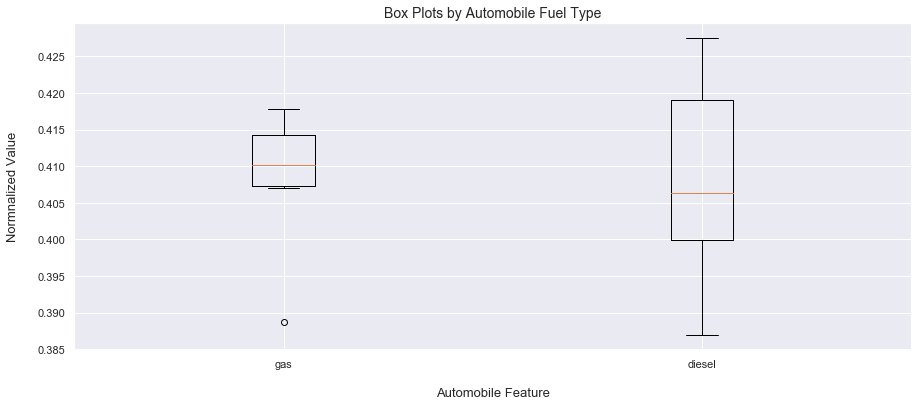

In [18]:
p=.03
stratified = stratify(auto_df, p, 'fuel-type')
categories = ['gas', 'diesel']
# GAS
strat_gas = stratified['fuel-type'] == categories[0]
strat_gas = stratified[strat_gas]
strat_gas.reset_index(inplace=True, drop=True)
stratLog_gas = getNormalCol(strat_gas, 'logPrice').tolist()
stratLog_gas = stratLog_gas[0]
# DIESEL
strat_diesel = stratified['fuel-type'] == categories[1]
strat_diesel = stratified[strat_diesel]
strat_diesel.reset_index(inplace=True, drop=True)
stratLog_diesel = getNormalCol(strat_diesel, 'logPrice').tolist()
stratLog_diesel = stratLog_diesel[0]

plt.figure(figsize=figArea)
plt.boxplot([stratLog_gas, stratLog_diesel])
plt.ylabel('Normnalized Value\n', fontsize=13)
plt.xlabel('\nAutomobile Feature', fontsize=13)
plt.title('Box Plots by Automobile Fuel Type', fontsize=14)
locs = [1, 2]
plt.xticks(locs, categories)
plt.show()

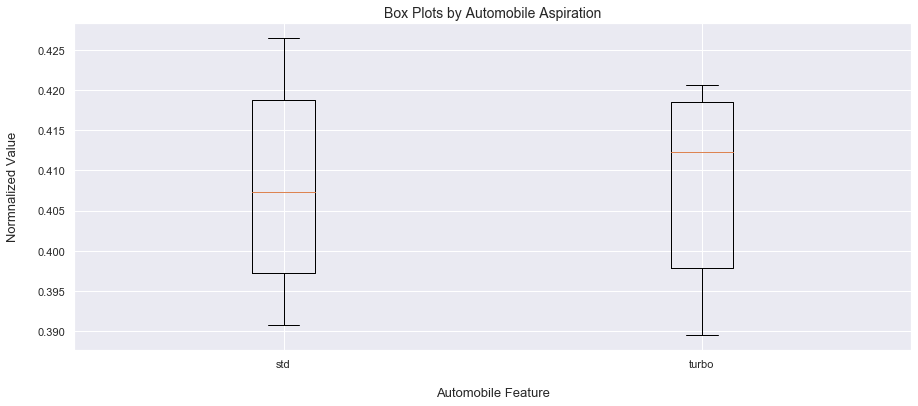

In [19]:
p=.03
stratified = stratify(auto_df, p, 'aspiration')
categories = ['std', 'turbo']
# STANDARD
strat_standard = stratified['aspiration'] == categories[0]
strat_standard = stratified[strat_standard]
strat_standard.reset_index(inplace=True, drop=True)
stratLog_standard = getNormalCol(strat_standard, 'logPrice').tolist()
stratLog_standard = stratLog_standard[0]
# TURBO
strat_turbo = stratified['aspiration'] == categories[1]
strat_turbo = stratified[strat_turbo]
strat_turbo.reset_index(inplace=True, drop=True)
stratLog_turbo = getNormalCol(strat_turbo, 'logPrice').tolist()
stratLog_turbo = stratLog_turbo[0]

plt.figure(figsize=figArea)
plt.boxplot([stratLog_standard, stratLog_turbo])
plt.ylabel('Normnalized Value\n', fontsize=13)
plt.xlabel('\nAutomobile Feature', fontsize=13)
plt.title('Box Plots by Automobile Aspiration', fontsize=14)
locs = [1, 2]
plt.xticks(locs, categories)
plt.show()

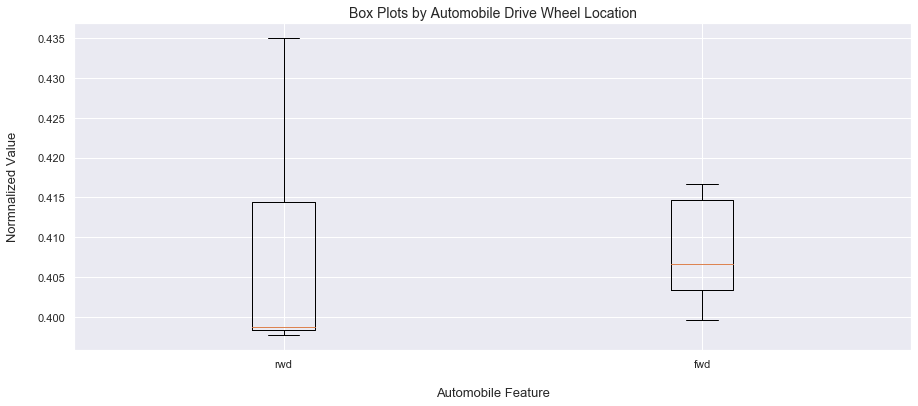

In [20]:
p=.03
stratified = stratify(auto_df, p, 'drive-wheels')
categories = ['rwd', 'fwd']
# GAS
strat_rwd = stratified['drive-wheels'] == categories[0]
strat_rwd = stratified[strat_rwd]
strat_rwd.reset_index(inplace=True, drop=True)
stratLog_rwd = getNormalCol(strat_rwd, 'logPrice').tolist()
stratLog_rwd = stratLog_rwd[0]
# DIESEL
strat_fwd = stratified['drive-wheels'] == categories[1]
strat_fwd = stratified[strat_fwd]
strat_fwd.reset_index(inplace=True, drop=True)
stratLog_fwd = getNormalCol(strat_fwd, 'logPrice').tolist()
stratLog_fwd = stratLog_fwd[0]

plt.figure(figsize=figArea)
plt.boxplot([stratLog_rwd, stratLog_fwd])
plt.ylabel('Normnalized Value\n', fontsize=13)
plt.xlabel('\nAutomobile Feature', fontsize=13)
plt.title('Box Plots by Automobile Drive Wheel Location', fontsize=14)
locs = [1, 2]
plt.xticks(locs, categories)
plt.show()

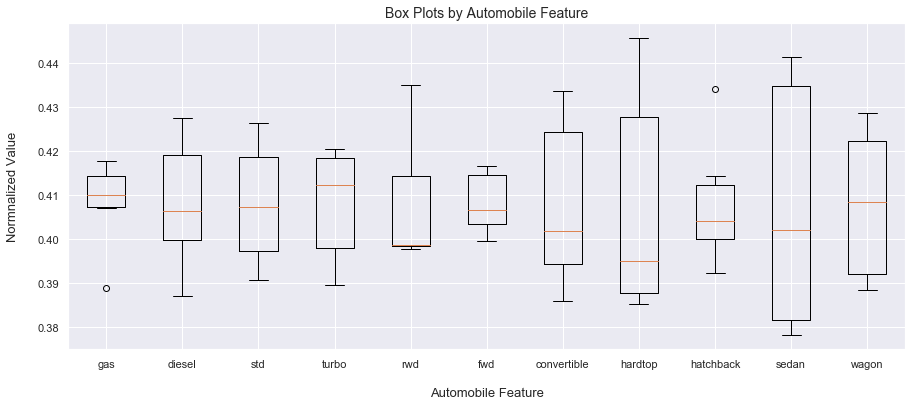

In [21]:
plt.figure(figsize=figArea)
plt.boxplot([stratLog_gas, stratLog_diesel,
             stratLog_standard, stratLog_turbo,
             stratLog_rwd, stratLog_fwd,
             stratLog_convertible, stratLog_hardtop, stratLog_hatchback, stratLog_sedan, stratLog_wagon
            ])
locs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
categories = ['gas', 'diesel', 'std', 'turbo', 'rwd', 'fwd', 'convertible', 'hardtop', 'hatchback', 'sedan', 'wagon']
plt.xticks(locs, categories)
plt.ylabel('Normnalized Value\n', fontsize=13)
plt.xlabel('\nAutomobile Feature', fontsize=13)
plt.title('Box Plots by Automobile Feature', fontsize=14)
plt.show()

## Item 5

5.Use standard ANOVA and Tukey HSD to test the differences of these groups.

### ANOVA TEST

In [22]:
f_statistic, p_value = ss.f_oneway(stratLog_gas, stratLog_diesel,
                                   stratLog_standard, stratLog_turbo,
                                   stratLog_rwd, stratLog_fwd,
                                   stratLog_convertible, stratLog_hardtop, stratLog_hatchback, stratLog_sedan, stratLog_wagon
                                  )
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 0.0012764140044766669
P-value = 0.9999999999998762


The F statistic is relatively small and the p-value is large. The null hypothesis that the 11 automobile features have the same mean is accepted, as the probability of the differences arising from random chance is quite high.

### TUKEY TEST

In [23]:
allVals = (stratLog_gas + stratLog_diesel + stratLog_standard + stratLog_turbo + stratLog_rwd + stratLog_fwd +
           stratLog_convertible + stratLog_hardtop + stratLog_hatchback + stratLog_sedan + stratLog_wagon
          )
df = pd.DataFrame({'vals': allVals,
                   'group_num': ['1']*len(stratLog_gas) + ['2']*len(stratLog_diesel) + ['3']*len(stratLog_standard) +
                   ['4']*len(stratLog_turbo) + ['5']*len(stratLog_rwd) + ['6']*len(stratLog_fwd) +
                   ['7']*len(stratLog_convertible) + ['8']*len(stratLog_hardtop) + ['9']*len(stratLog_hatchback) +
                   ['10']*len(stratLog_sedan) + ['11']*len(stratLog_wagon)
                  })
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     1     10  -0.0008   0.9 -0.0358 0.0342  False
     1     11  -0.0002   0.9 -0.0352 0.0348  False
     1      2  -0.0001   0.9 -0.0351 0.0349  False
     1      3  -0.0001   0.9 -0.0351 0.0349  False
     1      4  -0.0001   0.9 -0.0351 0.0349  False
     1      5  -0.0001   0.9 -0.0351 0.0349  False
     1      6   0.0001   0.9 -0.0349 0.0351  False
     1      7  -0.0003   0.9 -0.0353 0.0347  False
     1      8  -0.0006   0.9 -0.0356 0.0344  False
     1      9  -0.0001   0.9 -0.0351 0.0349  False
    10     11   0.0006   0.9 -0.0344 0.0356  False
    10      2   0.0007   0.9 -0.0343 0.0357  False
    10      3   0.0007   0.9 -0.0343 0.0357  False
    10      4   0.0007   0.9 -0.0343 0.0357  False
    10      5   0.0006   0.9 -0.0344 0.0356  False
    10      6   0.0008   0.9 -0.0342 0.0358  False
    10      7   0.0005   0.9 -

The Tukey result above shows complete agreement with the original hypothesis that the chosen automobile features already presented in this document are in fact statistically insignificant, such that the null hypothesis for these features can not be dismissed. Thus, each of these features is appropriate to use as a similar measure against an automobiles price point.